In [1]:
import re

import gensim
import keras
from keras import layers
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

2023-05-01 10:35:08.091355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('./kaggle/input/tweet-sentiment-extraction/train.csv')
train.head(15)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [3]:
len(train)

27481

In [4]:
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [5]:
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


In [6]:
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [7]:
train["selected_text"].isnull().sum()

1

In [8]:
train["selected_text"].fillna("No content", inplace = True)

In [9]:
def depure_data(data):
    
    # Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [10]:
temp = []
# Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [12]:
len(data_words)

27481

In [13]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [14]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [15]:
data = np.array(data)

In [16]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [17]:
len(labels)

27481

In [18]:
max_words = 5000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [19]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
print(len(X_train), len(X_test), len(y_train), len(y_test))

20610 6871 20610 6871


In [21]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(3, activation='softmax'))
model0.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)
history0 = model0.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks=[checkpoint0])

Epoch 1/5
643/645 [============================>.] - ETA: 0s - loss: 0.7544 - accuracy: 0.6790
Epoch 1: val_accuracy improved from -inf to 0.75695, saving model to best_model0.hdf5
645/645 [==============================] - 13s 20ms/step - loss: 0.7544 - accuracy: 0.6791 - val_loss: 0.6274 - val_accuracy: 0.7569
Epoch 2/5
645/645 [==============================] - ETA: 0s - loss: 0.5293 - accuracy: 0.7928
Epoch 2: val_accuracy improved from 0.75695 to 0.79261, saving model to best_model0.hdf5
645/645 [==============================] - 13s 20ms/step - loss: 0.5293 - accuracy: 0.7928 - val_loss: 0.5225 - val_accuracy: 0.7926
Epoch 3/5
645/645 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.8204
Epoch 3: val_accuracy improved from 0.79261 to 0.81153, saving model to best_model0.hdf5
645/645 [==============================] - 13s 19ms/step - loss: 0.4680 - accuracy: 0.8204 - val_loss: 0.5005 - val_accuracy: 0.8115
Epoch 4/5
642/645 [============================>.] -

In [22]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15, dropout=0.5))
model1.add(layers.Dense(3, activation='softmax'))
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)
history1 = model1.fit(X_train, y_train, epochs=70, validation_data=(X_test, y_test), callbacks=[checkpoint1])

Epoch 1/70


2023-05-01 10:36:16.906512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 10:36:16.907275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 10:36:16.907952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

645/645 [==============================] - ETA: 0s - loss: 0.8294 - accuracy: 0.6435

2023-05-01 10:36:41.956494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 10:36:41.957656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 10:36:41.958418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_accuracy improved from -inf to 0.70965, saving model to best_model1.hdf5
645/645 [==============================] - 27s 40ms/step - loss: 0.8294 - accuracy: 0.6435 - val_loss: 0.6758 - val_accuracy: 0.7096
Epoch 2/70
645/645 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.7653
Epoch 2: val_accuracy improved from 0.70965 to 0.78882, saving model to best_model1.hdf5
645/645 [==============================] - 26s 40ms/step - loss: 0.5871 - accuracy: 0.7653 - val_loss: 0.5316 - val_accuracy: 0.7888
Epoch 3/70
645/645 [==============================] - ETA: 0s - loss: 0.5104 - accuracy: 0.7998
Epoch 3: val_accuracy improved from 0.78882 to 0.80498, saving model to best_model1.hdf5
645/645 [==============================] - 25s 40ms/step - loss: 0.5104 - accuracy: 0.7998 - val_loss: 0.4942 - val_accuracy: 0.8050
Epoch 4/70
645/645 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.8193
Epoch 4: val_accuracy improved from 0.80498 to 0

In [23]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20, dropout=0.6)))
model2.add(layers.Dense(3, activation='softmax'))
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)
history2 = model2.fit(X_train, y_train, epochs=70, validation_data=(X_test, y_test), callbacks=[checkpoint2])

Epoch 1/70


2023-05-01 11:06:30.362251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 11:06:30.363201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 11:06:30.363857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

644/645 [============================>.] - ETA: 0s - loss: 0.7892 - accuracy: 0.6579

2023-05-01 11:06:58.236665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 11:06:58.237715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 11:06:58.238726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_accuracy improved from -inf to 0.74385, saving model to best_model2.hdf5
645/645 [==============================] - 30s 44ms/step - loss: 0.7891 - accuracy: 0.6579 - val_loss: 0.6310 - val_accuracy: 0.7439
Epoch 2/70
645/645 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.7674
Epoch 2: val_accuracy improved from 0.74385 to 0.77179, saving model to best_model2.hdf5
645/645 [==============================] - 27s 43ms/step - loss: 0.5790 - accuracy: 0.7674 - val_loss: 0.5500 - val_accuracy: 0.7718
Epoch 3/70
645/645 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.8010
Epoch 3: val_accuracy improved from 0.77179 to 0.80032, saving model to best_model2.hdf5
645/645 [==============================] - 28s 43ms/step - loss: 0.5065 - accuracy: 0.8010 - val_loss: 0.5055 - val_accuracy: 0.8003
Epoch 4/70
644/645 [============================>.] - ETA: 0s - loss: 0.4715 - accuracy: 0.8197
Epoch 4: val_accuracy improved from 0.80032 to 0

In [24]:
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3), bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3), bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3, activation='softmax'))
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)
history3 = model3.fit(X_train, y_train, epochs=70, validation_data=(X_test, y_test), callbacks=[checkpoint3])

Epoch 1/70
645/645 [==============================] - 3s 4ms/step - loss: 1.0540 - acc: 0.5384 - val_loss: 0.9175 - val_acc: 0.5980
Epoch 2/70
645/645 [==============================] - 3s 4ms/step - loss: 0.8826 - acc: 0.6053 - val_loss: 0.8746 - val_acc: 0.6203
Epoch 3/70
645/645 [==============================] - 2s 4ms/step - loss: 0.8454 - acc: 0.6200 - val_loss: 0.8680 - val_acc: 0.6116
Epoch 4/70
645/645 [==============================] - 3s 4ms/step - loss: 0.8160 - acc: 0.6395 - val_loss: 0.8147 - val_acc: 0.6609
Epoch 5/70
645/645 [==============================] - 3s 4ms/step - loss: 0.7856 - acc: 0.6933 - val_loss: 0.7889 - val_acc: 0.7299
Epoch 6/70
645/645 [==============================] - 3s 4ms/step - loss: 0.7563 - acc: 0.7425 - val_loss: 0.7842 - val_acc: 0.7158
Epoch 7/70
645/645 [==============================] - 3s 4ms/step - loss: 0.7295 - acc: 0.7597 - val_loss: 0.7913 - val_acc: 0.7335
Epoch 8/70
645/645 [==============================] - 2s 4ms/step - loss: 0.

In [25]:
best_model = keras.models.load_model("best_model2.hdf5")

2023-05-01 11:41:56.419798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 11:41:56.420729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 11:41:56.421546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [26]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ', test_accuracy)

2023-05-01 11:41:56.862761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 11:41:56.864196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 11:41:56.864994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/215 - 2s - loss: 0.4446 - accuracy: 0.8457 - 2s/epoch - 11ms/step
Model accuracy:  0.8457283973693848


In [27]:
predictions = best_model.predict(X_test)

2023-05-01 11:41:59.224564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-01 11:41:59.225304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-01 11:41:59.226219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

215/215 [==============================] - 2s 9ms/step


In [28]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

In [29]:
conf_matrix = pd.DataFrame(matrix, index=['Neutral', 'Negative', 'Positive'], columns=['Neutral', 'Negative', 'Positive']).to_numpy()

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15, 15))

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Axes: >

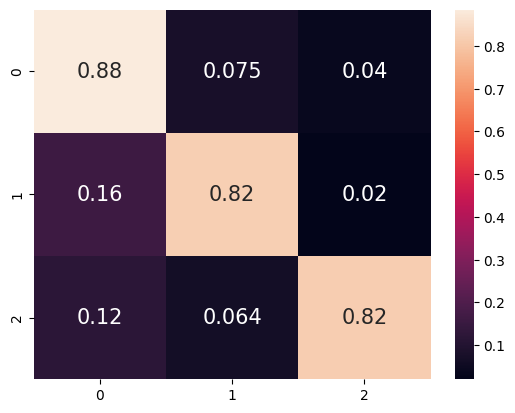

In [30]:
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [31]:
sentiment = ['Neutral', 'Negative', 'Positive']
sequence = tokenizer.texts_to_sequences(["""
Research Statement
Zhangchunsheng
Research background
I was educated at Sichuan University, majoring in Mechanical Design, Manufacture, and Automatization from 2008 to 2012. But after my graduation, I became more and more interested in computer science and artificial intelligence, and I quit my first job as an automotive engineer at FAW(First Automobile Works) and made up my mind to find a job in computer science and artificial intelligence.

In 2016, I got my first programming job in Beijing. In 2018, I joined Bytedance Co., Ltd. and have been working for almost five years since then. I'm familiar with C/C++, GO, Python, PHP, Node.js, and many other programming languages. I can get familiar with any programming language or software framework in a week.

During Bytedance, I mainly constructed a CI/CD platform called Bits. Now, the Bits platform has fully supported the mobile app CI/CD process in ByteDance. The whole mobile app CI/CD process, from the developer's first line of code to the delivery of the app to AppStore, is completed through this platform. In constructing platform functions, I mainly develop and maintain the platform's core process and mid-term planning. I currently host our group's agile process stand-up meeting, regularly assigning tasks, checking progress, and reporting timely follow-ups and results.

I am very interested in scientific research but have little research experience. However, I think I have a characteristic no one can compare to. I have high execution ability and will stick to the goal once I set it. I believe scientific research should also need this ability.
Research interests
I don't have a profound understanding of cutting-edge computer science and artificial intelligence, but I think natural language processing, computer vision, and multimodal machine learning are challenging and essential.

Although our computer vision is relatively mature, it is still far from biological intelligence. Although computer vision can distinguish people, dogs, and cats, this differs from what humans do in the real world. The computer trains the model through a large amount of data and pictures, then learns to distinguish these. But humans are different. After a child sees a cat, he knows it is a cat and will never misjudge it. If the computer has seen a biological dog and a toy dog that looks alike, it is likely to misjudge them since their images are similar. A child will never mistake a biological dog and a toy dog.

The same is true for natural language processing. Although the current ChatGPT is very popular, it does not reason and induct like a human. My colleagues and I have run some tests on ChatGPT. We asked it to establish a regular expression from some English sentences. It is straightforward for people to recognize the pattern. The difficulty lies in generating the regular expression for humans. But ChatGPT still couldn't induct the correct rules after several rounds of questioning. ChatGPT is more like an intelligent search engine. It is just like a child who has learned a lot of knowledge. If you ask him what he has learned, he will quickly come up with the answer, but there seem to be some deficiencies in reasoning and inducting.

For multimodal machine learning, I think this is closer to reality. Because it is difficult to understand the meaning of words, sounds, or images alone, even for humans. A classic example is "Story of Stone Grotto Poet Eating Lions." All the Chinese characters in this short article are read in Chinese "shi." You don't know what he is talking about if you don't read the text. So I think what can be applied to people's daily lives should probably be multimodal machine learning.
Research plan
I think when we use a lot of data to train the model, we are already far from the mechanism of our actual brain. A child doesn't need hundreds or thousands of photos to identify a cat. I wonder if we can use a small number of samples for model training. Just imagine, if we want to make an artificial intelligence that can reason independently, it will face the same complex world as humans. We can't fill it with all possible data and pictures from the moment it is created and let it carry out model training. There are always some scenes that it has never met before. The correct approach should be to let it learn these things through a small amount of training. This is what we should do, and it is also how to make AI closer to humans.

"""])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 21ms/step


'Neutral'